In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU

In [2]:
phis=[0.93,1.0,1.10] 
Ts=[1160,1200,1130]

name_11='State_space_cte_pressure_T' 
name_12='_phi_'
name_21='Reaction_rates_cte_pressure_T'
name_22='_phi_'

end='.csv'

In [3]:
def hydrogen_data_clean_shift_sandiego_cantera(cantera_species,cantera_sources,maximum_values):
    cantera_sources=cantera_sources.add_suffix('w')
    cantera_sources=cantera_sources.iloc[:,1:] #for taking out the timestep as data 
    
    cantera_time=cantera_species.iloc[:,1]
    cantera_temperature=cantera_species.iloc[:,2]
    cantera_pressure=cantera_species.iloc[:,3]
    
    cantera_species_fractions=cantera_species.iloc[:,4:12]
    
    n_columns_mass_fraction=np.shape(cantera_species_fractions)[1]
    
    cantera_sources=cantera_sources.loc[:,(cantera_sources!=0).any(axis=0)]
    cantera_sources=cantera_sources.loc[:, (cantera_sources != cantera_sources.iloc[0]).any()]
    
    n_columns_source=np.shape(cantera_sources)[1]
    
    cantera_data=pd.concat([cantera_time, cantera_temperature,cantera_species_fractions,cantera_sources],axis=1)

    maximum_values=maximum_values.iloc[0,1:]
    maximum_values=maximum_values.to_numpy()
    
    iterations=np.shape(cantera_data)[1]
    
    #cantera_data.divide(maximum_values)
    for j in range(iterations):
        cantera_data.iloc[:,j]=cantera_data.iloc[:,j]/(maximum_values[j])
    
    cantera_data_shift=cantera_data.loc[1:,:]
    cantera_data_shift=cantera_data_shift.add_suffix('shift')
    
    cantera_data=cantera_data.reset_index()
    cantera_data_shift=cantera_data_shift.reset_index()
    
    cantera_data=cantera_data.iloc[:,1:]
    cantera_data_shift=cantera_data_shift.iloc[:,1:]

    cantera_data=cantera_data.iloc[0:(np.shape(cantera_data_shift)[0]),:]
    
    data_all=pd.concat([cantera_data, cantera_data_shift], axis=1)

    columns=data_all.columns.to_list()
    
    return data_all, n_columns_source, n_columns_mass_fraction, columns

In [4]:
k=2
cantera_species=pd.read_csv(name_11+str(Ts[k])+name_12+str(phis[k])+end)
cantera_species=pd.DataFrame(cantera_species)

cantera_sources=pd.read_csv(name_21+str(Ts[k])+name_22+str(phis[k])+end)
cantera_sources=pd.DataFrame(cantera_sources)

maximum_values=pd.read_csv('maximum_values_Phi_T_Sampling.csv')
maximum_values=pd.DataFrame(maximum_values)

In [5]:
dataset, n_columns_source, n_columns_mass_fraction, columns=hydrogen_data_clean_shift_sandiego_cantera(cantera_species,cantera_sources,maximum_values)

In [6]:
outputs=dataset.iloc[:,3+n_columns_mass_fraction+n_columns_source:4+2*n_columns_mass_fraction+n_columns_source]
outputs

,T[K]shift,H2shift,Hshift,O2shift,OHshift,Oshift,H2Oshift,HO2shift,H2O2shift
0,0.405757,0.971234,6.014564e-10,0.994361,3.189426e-11,5.045361e-11,1.892945e-12,9.209433e-07,2.241949e-10
1,0.405757,0.971234,8.991601e-10,0.994361,6.241024e-11,1.079589e-10,5.724130e-12,1.385850e-06,5.054338e-10
2,0.405757,0.971234,1.197712e-09,0.994361,9.834179e-11,1.830035e-10,1.230312e-11,1.853703e-06,9.003646e-10
3,0.405757,0.971234,1.498501e-09,0.994361,1.383374e-10,2.733067e-10,2.201249e-11,2.324521e-06,1.409677e-09
4,0.405757,0.971234,1.802642e-09,0.994361,1.816197e-10,3.769934e-10,3.515383e-11,2.798329e-06,2.034066e-09
...,...,...,...,...,...,...,...,...,...
4994,0.989192,0.153838,1.399595e-01,0.050045,7.513178e-01,1.601142e-01,9.858607e-01,4.845972e-02,2.044816e-02
4995,0.989192,0.153838,1.399595e-01,0.050045,7.513178e-01,1.601142e-01,9.858607e-01,4.845972e-02,2.044816e-02
4996,0.989192,0.153838,1.399595e-01,0.050045,7.513178e-01,1.601142e-01,9.858607e-01,4.845972e-02,2.044816e-02
4997,0.989192,0.153838,1.399595e-01,0.050045,7.513178e-01,1.601142e-01,9.858607e-01,4.845972e-02,2.044816e-02


In [7]:
Inputs=pd.concat([dataset.loc[:,'T[K]'], dataset.loc[:,'O2'], dataset.loc[:,'O']],axis=1)

Outputs=outputs

whole_data=pd.concat([Inputs, Outputs],axis=1)

In [8]:
from sklearn.model_selection import train_test_split

Inputs=whole_data.iloc[:,0:3]
Outpus=whole_data.iloc[:,3:]
#10% will be testing data
X_train, X_test, y_train, y_test = train_test_split(Inputs, Outputs, test_size=0.1, random_state=42)


out_columns=dataset.iloc[:,1:2+n_columns_mass_fraction].columns.to_list()

In [9]:
x1=X_train.iloc[:,0]
x2=X_train.iloc[:,1]
x3=X_train.iloc[:,2]
#x4=X_train.iloc[:,3]
#x5=X_train.iloc[:,4]

In [10]:
regression_inputs=pd.concat([x1, x2, x3],axis=1)
regression_inputs

,T[K],O2,O
3931,0.989189,0.050046,1.601204e-01
47,0.405757,0.994361,1.173676e-08
4519,0.989192,0.050045,1.601149e-01
4610,0.989192,0.050045,1.601147e-01
1728,0.982485,0.052812,1.718732e-01
...,...,...,...
4426,0.989192,0.050045,1.601152e-01
466,0.405971,0.993050,9.851260e-04
3092,0.989128,0.050071,1.602249e-01
3772,0.989186,0.050047,1.601249e-01


In [11]:
from sklearn.linear_model import LinearRegression

iterations=np.shape(Outputs)[1]
inputs=np.shape(regression_inputs)[1]

coefficients_ch=np.zeros((iterations,inputs))
intercepts_ch=np.zeros((iterations))
scores_ch=np.zeros((iterations))

results_ch=np.zeros((iterations,inputs))

In [12]:
from sklearn.inspection import permutation_importance

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold

n_split=5
n_repeats=3

for k in range(iterations):

    for train_index,test_index in RepeatedKFold(n_splits=n_split, n_repeats=n_repeats,random_state=42).split(regression_inputs):
    
        x_train,x_test=regression_inputs.iloc[train_index],regression_inputs.iloc[test_index]
        Y_train,Y_test=y_train.iloc[train_index],y_train.iloc[test_index]

        
        reg = LinearRegression().fit(x_train, Y_train.iloc[:,k])
        
        
        result = permutation_importance(reg, x_test, Y_test.iloc[:,k], n_repeats=10, random_state=42)
        results_ch[k,:]=result.importances_mean
        
        score=reg.score(x_train, Y_train.iloc[:,k])
        scores_ch[k]=score
        
        coeff=reg.coef_
        coefficients_ch[k,:]=coeff
        
        intercept=reg.intercept_
        intercepts_ch[k]= intercept


In [14]:
results_ch_dataframe=pd.DataFrame(results_ch, index=outputs.columns.to_list())

In [15]:
iterations=np.shape(results_ch)[0]

for i in range(iterations):
    summ=results_ch_dataframe.iloc[i,:].sum()
    results_ch_dataframe.iloc[i,:]=results_ch_dataframe.iloc[i,:]/summ
    

In [16]:
results_ch_dataframe

,0,1,2
T[K]shift,0.996408,0.003485,0.000107
H2shift,0.206908,0.785162,0.007930
Hshift,0.462154,0.529350,0.008496
O2shift,0.021481,0.977518,0.001000
OHshift,0.543208,0.418919,0.037873
Oshift,0.239436,0.277019,0.483545
H2Oshift,0.108342,0.881405,0.010253
HO2shift,0.469841,0.509060,0.021100
H2O2shift,0.474248,0.515319,0.010433


In [17]:
barWidth = 0.25

#rho_spar=dataset.columns.to_list()
T_weights=results_ch_dataframe.iloc[:,0]

br1 = np.arange(len(T_weights))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]

In [18]:
O2_weights=results_ch_dataframe.iloc[:,1]
O_weights=results_ch_dataframe.iloc[:,2]
#OH_weights=results_ch_dataframe.iloc[:,3]
#O2_weights=results_ch_dataframe.iloc[:,4]

labels=dataset.iloc[:,1:2+n_columns_mass_fraction].keys()
print(labels)

Index(['T[K]', 'H2', 'H', 'O2', 'OH', 'O', 'H2O', 'HO2', 'H2O2'], dtype='object')


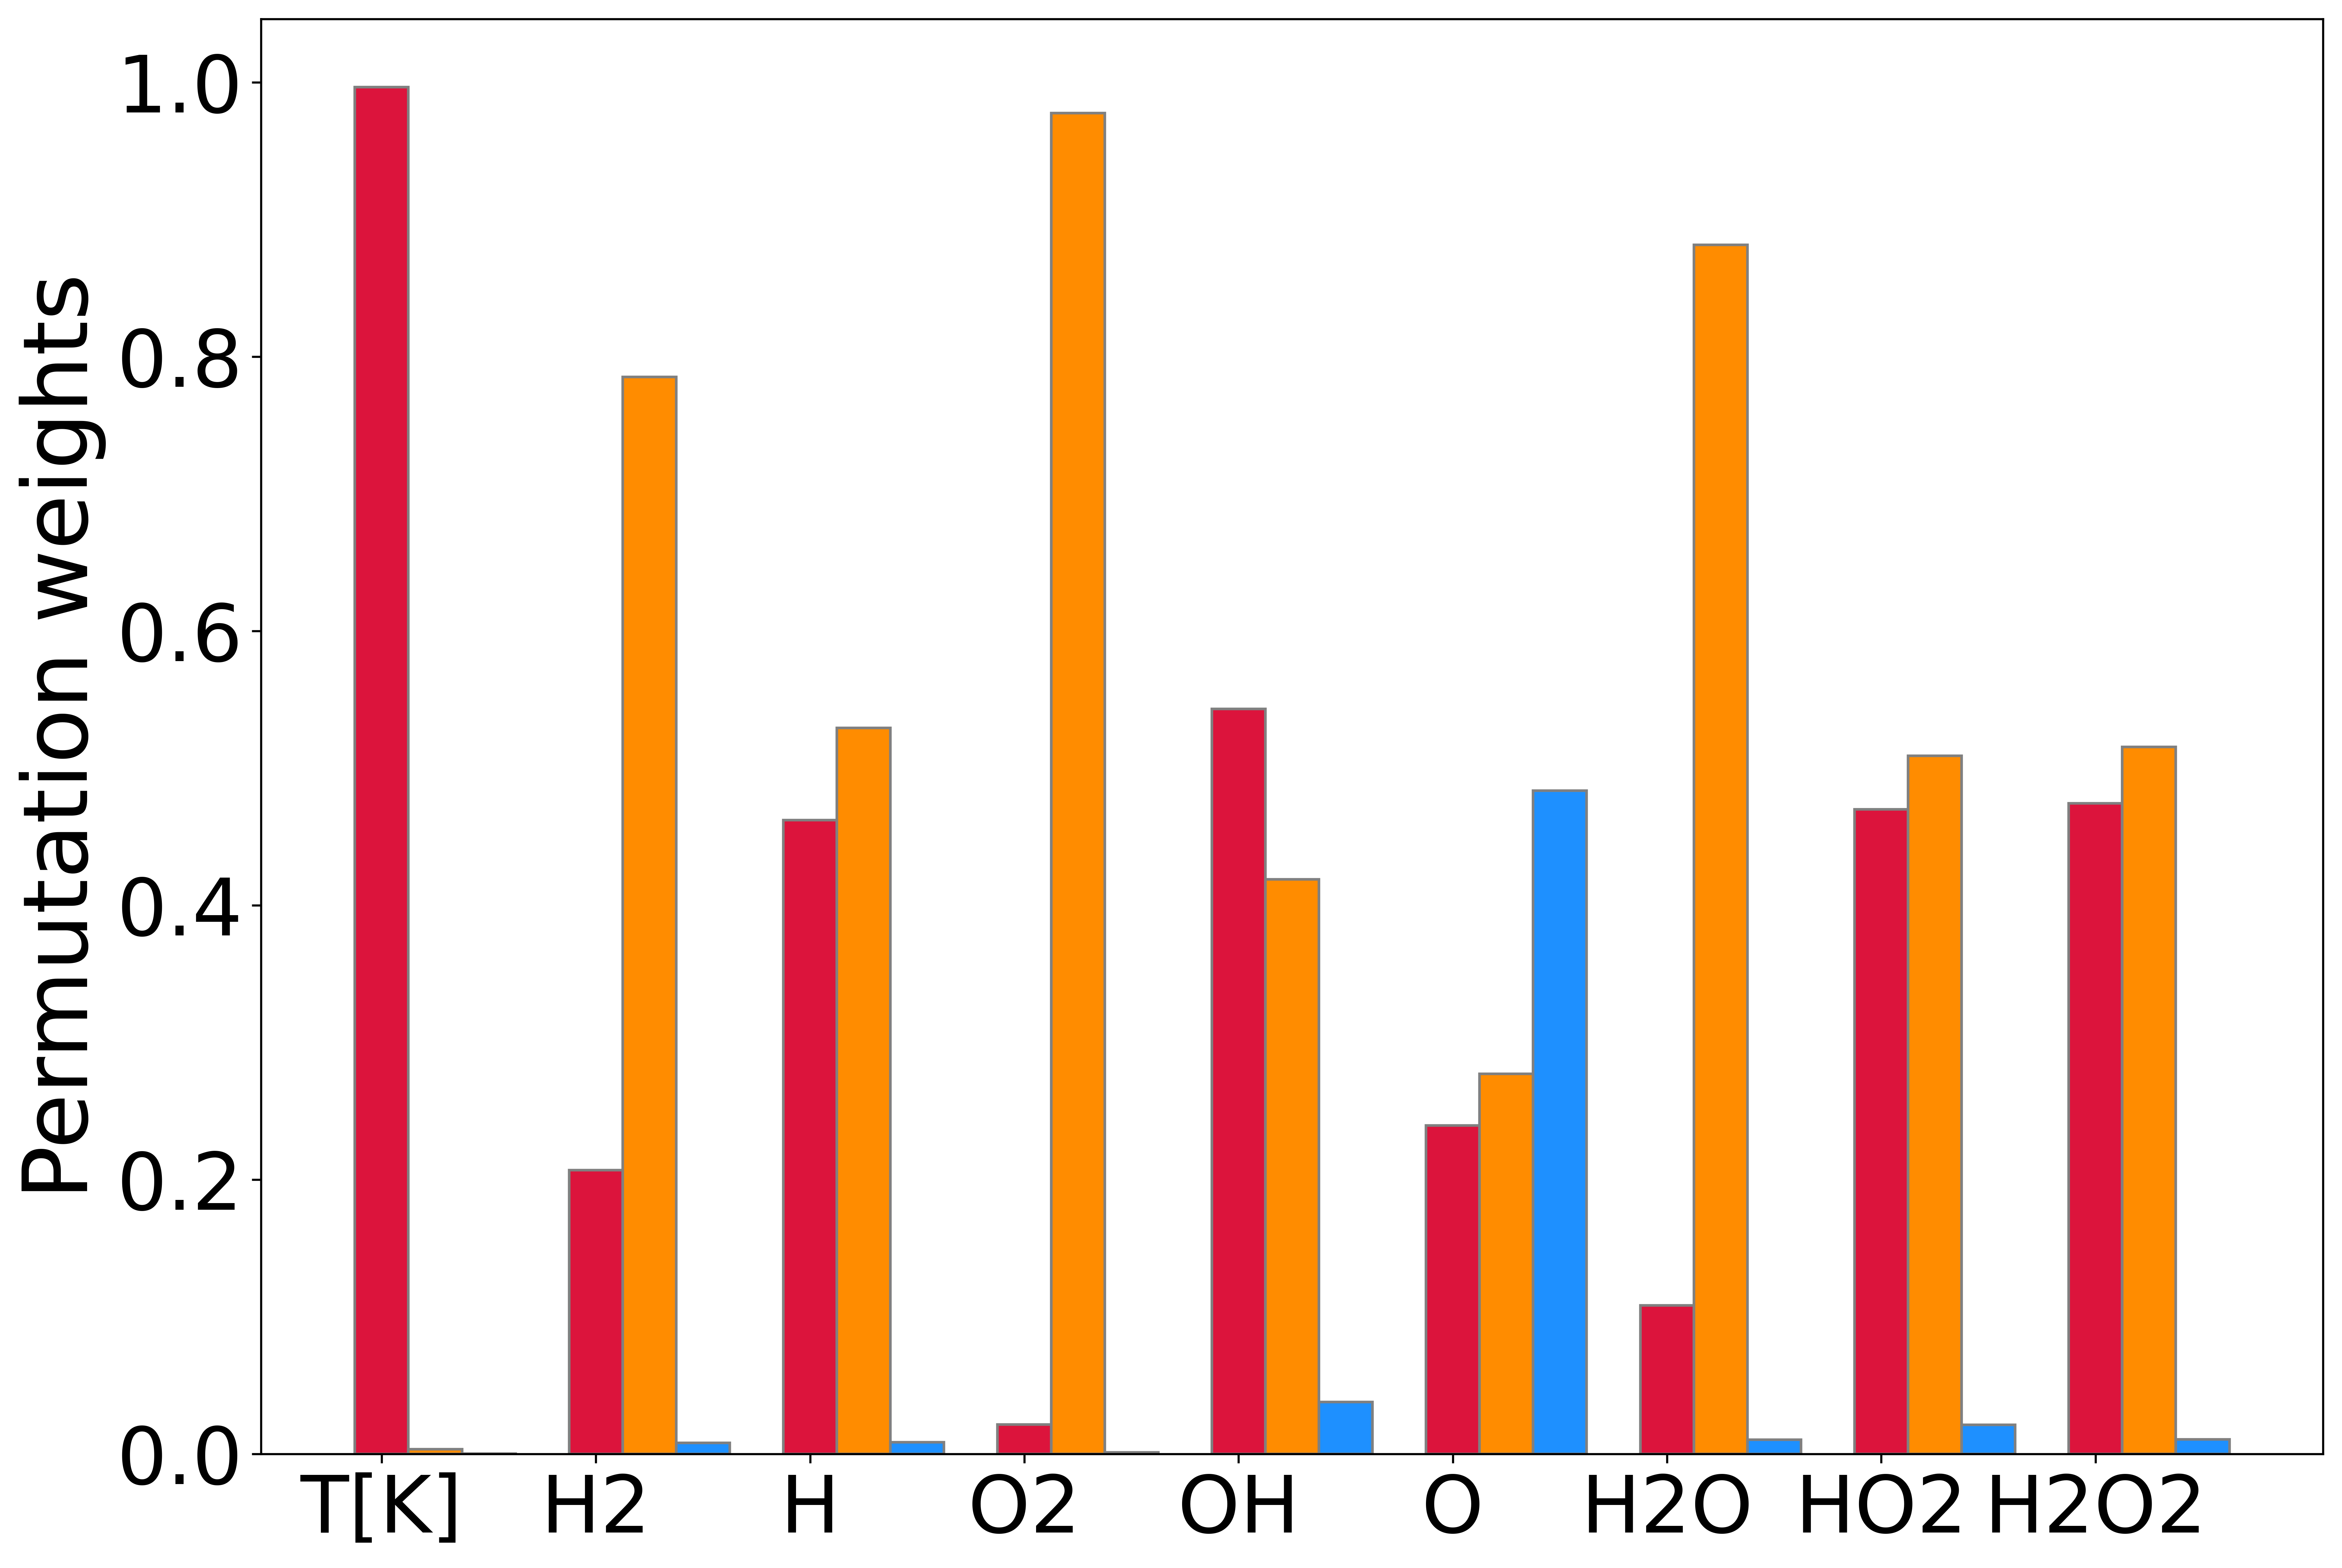

In [20]:
fig,ax = plt.subplots(figsize =(14, 10),dpi=600)
    # Make the plot
p1=ax.bar(br1, T_weights, color ='crimson', edgecolor ='grey',width = barWidth, label ='T[K]')
p2=ax.bar(br2, O2_weights, color ='darkorange', edgecolor ='grey',width = barWidth, label ='O2')
p3=ax.bar(br3, O_weights, color ='dodgerblue', edgecolor ='grey',width = barWidth, label ='O')
#p4=ax.bar(br4, OH_weights,color='grey',edgecolor ='grey',width = barWidth, label ='OH' )
#p5=ax.bar(br4, O2_weights,color='darkorange',edgecolor ='grey',width = barWidth, label ='O2' )

ax.set_ylabel(r'Permutation weights', fontsize = 34)
ax.set_xticks(br1,labels=labels, fontsize=30)
#plt.legend(loc='best', fontsize=15)
plt.yticks(fontsize=30)
plt.show()
fig.savefig('permutation_importance_4.jpg',dpi=600)